In [1]:
import warnings
warnings.filterwarnings('ignore')

## Paso 1: Conexión a BigQuery y obtención de datos

In [2]:
from google.cloud import bigquery
import pandas as pd

# Conexión a BigQuery
client = bigquery.Client.from_service_account_json('./dbt-bigquery-key.json')

# Consulta SQL para obtener los datos
query = """
    SELECT COUNT(*) AS casos, fecha_diagnostico AS fecha
    FROM `dm-09242024.cleaned.casos positivos covid-19`
    WHERE fecha_diagnostico < "2023-01-01"
    GROUP BY fecha
    ORDER BY fecha
"""
df = client.query(query).to_dataframe()

# Asegúrate de que las fechas sean tipo datetime
df['fecha'] = pd.to_datetime(df['fecha'])

## Paso 2: Preprocesamiento y resampling

<Axes: xlabel='fecha'>

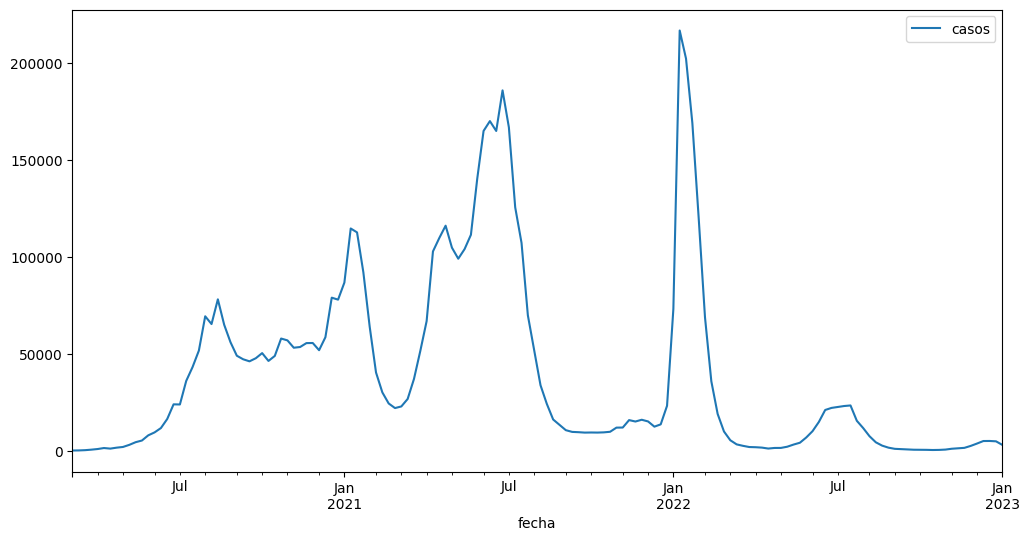

In [3]:
# Establecemos la fecha de diagnóstico como índice
df.set_index('fecha', inplace=True)

# Realizamos un resampling por semana
df_resampled = df.resample('W').sum().dropna()

# Asegurémonos de que los datos están listos para la predicción
df_resampled.plot(figsize=(12, 6))

## Paso 3: Predicción con Darts

In [4]:
from darts import TimeSeries
from darts.models import ARIMA, RandomForest, NBEATSModel
from darts.metrics import rmse, mape, mae
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import itertools

# Crear función para métricas adicionales
def calculate_metrics(test, predictions):
    rmse_val = rmse(test, predictions)
    mape_val = mape(test, predictions)
    mae_val = mae(test, predictions)
    return { 'RMSE': rmse_val, 'MAPE': mape_val, 'MAE': mae_val }

# Cargar y convertir los datos
ts = TimeSeries.from_dataframe(df_resampled, value_cols=['casos'])
train, test = ts.split_before(pd.Timestamp('2022-01-01'))

# Configuración de los hiperparámetros
arima_params = [{'p': p, 'd': d, 'q': q} for p, d, q in itertools.product([1, 2, 3], [0, 1], [1, 2, 3])]
rf_params = [{'lags': l, 'n_estimators': n, 'max_depth': d} for l, n, d in itertools.product([6, 12, 18], [100, 300, 500], [10, 15, 20])]
nbeats_params = [{'input_chunk_length': 12, 'output_chunk_length': 6}, {'input_chunk_length': 24, 'output_chunk_length': 12}]

# Función de optimización
best_models = {}
best_metrics = {}

def train_and_evaluate(model_class, param_grid, name):
    best_rmse = float('inf')
    for params in param_grid:
        try:
            # Crear y ajustar el modelo
            model = model_class(**params)
            model.fit(train)
            predictions = model.predict(len(test))

            # Calcular métricas
            metrics = calculate_metrics(test, predictions)

            # Actualizar si este modelo es el mejor
            if metrics['RMSE'] < best_rmse:
                best_rmse = metrics['RMSE']
                best_models[name] = model
                best_metrics[name] = metrics
        except Exception as e:
            print(f"Error with {name} and params {params}: {e}")

# Entrenar y evaluar modelos
print("Optimizando modelo ARIMA...")
train_and_evaluate(ARIMA, arima_params, "ARIMA")

print("Optimizando modelo Random Forest...")
train_and_evaluate(RandomForest, rf_params, "Random Forest")

print("Optimizando modelo N-BEATS...")
train_and_evaluate(NBEATSModel, nbeats_params, "N-BEATS")

The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(UTC)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.


Optimizando modelo ARIMA...
Optimizando modelo Random Forest...
Optimizando modelo N-BEATS...


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.1 M  | train
-------------------------------------------------------------
6.1 M     Trainable params
1.4 K     Non-trainable params
6.1 M     Total params
24.406    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 3/3 [00:00<00:00,  6.27it/s, train_loss=1.15e+7]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 3/3 [00:00<00:00,  6.07it/s, train_loss=1.15e+7]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.2 M  | train
-------------------------------------------------------------
6.2 M     Trainable params
1.4 K     Non-trainable params
6.2 M     Total params
24.787    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 2/2 [00:00<00:00,  6.11it/s, train_loss=2.47e+6]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00,  6.11it/s, train_loss=2.47e+6]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.56it/s]


## Paso 4: Graficar los resultados

In [5]:
metrics_df = pd.DataFrame(best_metrics).T
print("Métricas de evaluación de los mejores modelos:")
print(metrics_df)

Métricas de evaluación de los mejores modelos:
                       RMSE         MAPE           MAE
ARIMA          48110.055749  1952.676660  34534.448158
Random Forest  48718.809488  1944.288647  34824.650000
N-BEATS        45163.107676   106.497414  18069.054550


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.69it/s]


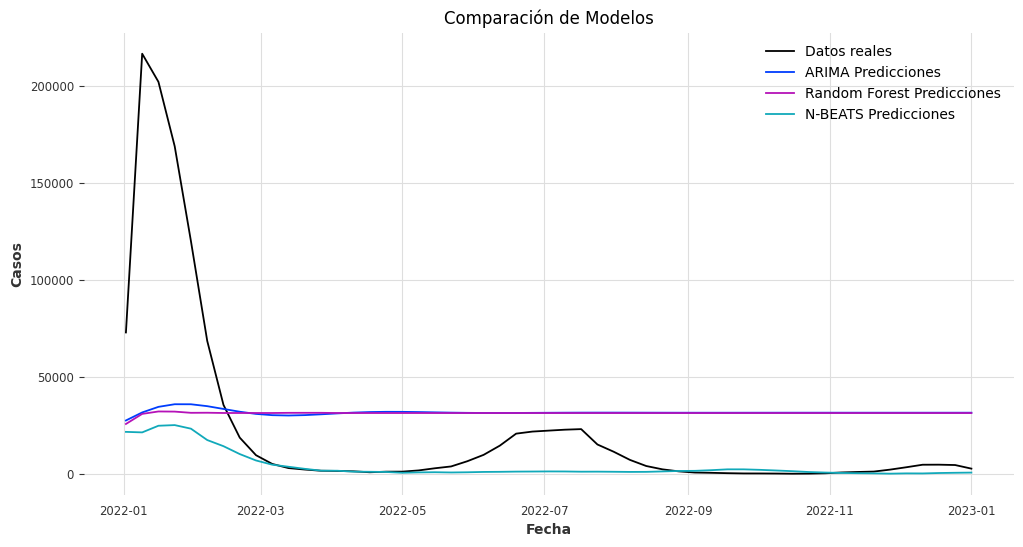

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(test.time_index, test.values(), label="Datos reales")
for name, model in best_models.items():
    predictions = model.predict(len(test))
    plt.plot(test.time_index, predictions.values(), label=f"{name} Predicciones")
plt.legend()
plt.xlabel("Fecha")
plt.ylabel("Casos")
plt.title("Comparación de Modelos")
plt.show()